In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
p = kagglehub.dataset_download('uciml/electric-power-consumption-data-set')

print('Data source import complete.')


100%|██████████| 19.4M/19.4M [00:01<00:00, 18.9MB/s]

Extracting files...


Data source import complete.


In [2]:
p+="/household_power_consumption.txt"

In [3]:
p

'/root/.cache/kagglehub/datasets/uciml/electric-power-consumption-data-set/versions/1/household_power_consumption.txt'

Data shape after feature engineering: (34589, 13)

PyTorch Model Architecture:
BidirectionalLSTMAttention(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention_weights): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 1/30 | Train Loss: 0.0335 | Val Loss: 0.0304 | LR: 0.001000
Epoch 2/30 | Train Loss: 0.0107 | Val Loss: 0.0257 | LR: 0.001000
Epoch 3/30 | Train Loss: 0.0062 | Val Loss: 0.0149 | LR: 0.001000
Epoch 4/30 | Train Loss: 0.0045 | Val Loss: 0.0069 | LR: 0.001000
Epoch 5/30 | Train Loss: 0.0032 | Val Loss: 0.0039 | LR: 0.001000
Epoch 6/30 | Train Loss: 0.0023 | Val Loss: 0.0054 | LR: 0.001000
Epoch 7/30 | Train Loss: 0.0021 | Val Loss: 0.0061 | LR: 0.001000
Epoch 8/30 | Train Loss: 0.0021 | Val Loss: 0.0025 | LR: 0.001000
Epoch 9/30 | Train Loss: 0.0015 | Val Loss: 0.0017 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0008 | Val Loss: 0.0018 | LR: 0.000100
Epoch 11

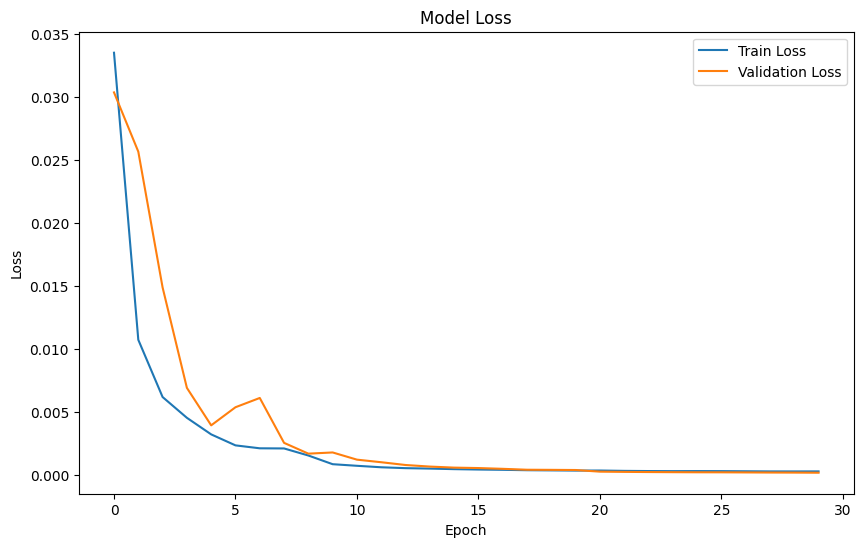


Test RMSE: 0.080


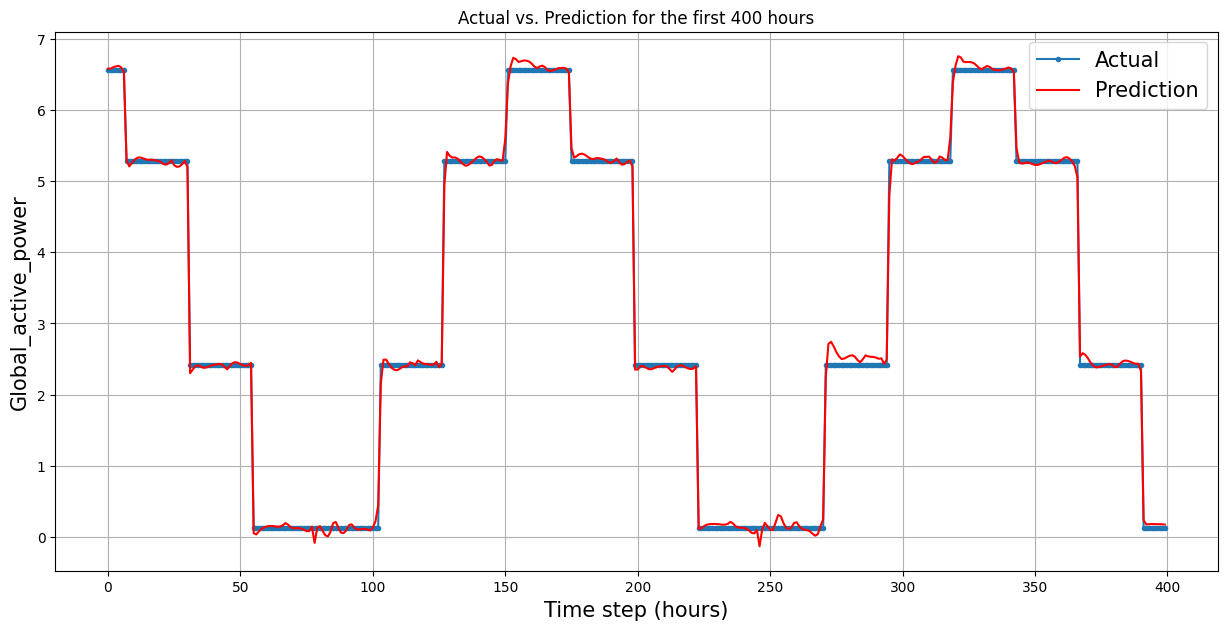

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# PyTorch Imports
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# --- 1. DATA LOADING AND FEATURE ENGINEERING ---

# Load the dataset
df = pd.read_csv(p, sep=';',
                 low_memory=False, na_values=['nan', '?'])

# Optimized Date Parsing
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('dt')
df = df.drop(['Date', 'Time'], axis=1)

# Fill missing values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# Resample to hourly frequency
df_resample = df.resample('h').mean()

## --- NEW: Advanced Feature Engineering ---
# Create time-based features to help the model understand cycles
df_resample['hour'] = df_resample.index.hour
df_resample['day_of_week'] = df_resample.index.dayofweek
df_resample['day_of_year'] = df_resample.index.dayofyear
df_resample['month'] = df_resample.index.month

# Encode cyclical features using sine and cosine to preserve their nature
# This is crucial for time-based features
df_resample['hour_sin'] = np.sin(2 * np.pi * df_resample['hour']/24.0)
df_resample['hour_cos'] = np.cos(2 * np.pi * df_resample['hour']/24.0)
df_resample['day_of_week_sin'] = np.sin(2 * np.pi * df_resample['day_of_week']/7.0)
df_resample['day_of_week_cos'] = np.cos(2 * np.pi * df_resample['day_of_week']/7.0)

# Drop the original non-encoded time features
df_resample = df_resample.drop(['hour', 'day_of_week'], axis=1)

print("Data shape after feature engineering:", df_resample.shape)


# --- 2. HELPER FUNCTION (Unchanged) ---
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# --- 3. DATA PREPARATION FOR PYTORCH ---
# The target variable 'Global_active_power' should be the first column for easy slicing
cols = ['Global_active_power'] + [col for col in df_resample.columns if col != 'Global_active_power']
df_resample = df_resample[cols]

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_steps = 24
n_features = df_resample.shape[1] # Now has more features
reframed = series_to_supervised(scaled, n_steps, 1)
reframed.drop(reframed.columns[[(n_steps * n_features) + i for i in range(n_features - 1)]], axis=1, inplace=True)

values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

train_X_tensor = torch.from_numpy(train_X).float()
train_y_tensor = torch.from_numpy(train_y).float().view(-1, 1)
test_X_tensor = torch.from_numpy(test_X).float()
test_y_tensor = torch.from_numpy(test_y).float().view(-1, 1)

batch_size = 70
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# --- 4. A MORE POWERFUL PYTORCH MODEL ---
class BidirectionalLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout):
        super(BidirectionalLSTMAttention, self).__init__()
        # Using 2 stacked, bidirectional LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Attention mechanism weights
        # The input to this layer is hidden_dim * 2 because the LSTM is bidirectional
        self.attention_weights = nn.Linear(hidden_dim * 2, 1)

        # Final output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # The LSTM output contains all hidden states for the sequence
        # The shape of lstm_out will be (batch_size, seq_len, hidden_dim * 2)
        lstm_out, _ = self.lstm(x)

        attn_scores = self.attention_weights(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)

        # Calculate the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)

        out = self.fc(context_vector)
        return out

# Model hyperparameters
INPUT_DIM = n_features
HIDDEN_DIM = 128  # Increased hidden dimension
N_LAYERS = 2      # Using 2 stacked LSTM layers
OUTPUT_DIM = 1
DROPOUT = 0.2

model = BidirectionalLSTMAttention(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# NEW: Learning Rate Scheduler
# This will decrease the learning rate by a factor of 0.1 every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print("\nPyTorch Model Architecture:")
print(model)


# --- 5. PYTORCH TRAINING LOOP ---
epochs = 30 # Increased epochs for the more complex model
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step() # Update the learning rate
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    validation_loss = running_val_loss / len(test_loader)
    val_losses.append(validation_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {validation_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


# --- 6. EVALUATE AND VISUALIZE RESULTS ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    yhat_tensor = model(test_X_tensor)

yhat = yhat_tensor.numpy()

inv_yhat = np.concatenate((yhat, test_X[:, -1, 1:n_features]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

inv_y = np.concatenate((test_y.reshape(-1,1), test_X[:, -1, 1:n_features]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('\nTest RMSE: %.3f' % rmse)

plt.figure(figsize=(15, 7))
aa = [x for x in range(400)]
plt.plot(aa, inv_y[:400], marker='.', label="Actual")
plt.plot(aa, inv_yhat[:400], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step (hours)', size=15)
plt.legend(fontsize=15)
plt.title('Actual vs. Prediction for the first 400 hours')
plt.grid(True)
plt.show()